# Geostructures: Working with Coordinates and Shapes

This notebook will demonstrate:
* Coordinates
* Creating shapes
* Bounding shapes by time
* Basic shape operations
* Converting shapes into alternate formats

In [9]:
# If you've git cloned this repo, run this cell to add `geostructures` to your python path
import sys
sys.path.insert(0, '../')

In [2]:
from datetime import datetime

from geostructures import *
from geostructures.visualization.plotly import draw_collection

## Coordinates

Geostructures provides a `Coordinate` object that can be instanced with the longitude and latitude (in that order). It's important to note that geostructures expects all coordinates to be defined using the WGS84 standard.

In [3]:
# All of these are equivalent

centroid = Coordinate(-0.118092, 51.509865)

centroid = Coordinate('-0.118092', '51.509865')

centroid = Coordinate(
    longitude=-0.118092, 
    latitude=51.509865
)

### Coordinate Precision

A longitude of 1.0 is not necessarily equivalent to 1.000 because a higher degree of accuracy is implied. Python will automatically convert 1.000 to 1.0, so Geostructures Coordinates use the `precisenumbers` package to preserve the original level of precision (when the value is passed as a string).

In [4]:
centroid_imprecise = Coordinate(0.0, 1.0)
centroid_precise = Coordinate('0.0000', '1.0000')

print("Less precise latitude:", centroid_imprecise.latitude.precision)
print("More precise latitude:", centroid_precise.latitude.precision)

Less precise latitude: 1
More precise latitude: 4


### Working with alternate formats

Coordinates are most often found in decimal format, but many different systems exist. Geostructures can create coordinates from and convert them back to:
* Degrees, minutes, seconds
* Quadrant format
* MGRS

In [5]:
centroid.to_mgrs()

'30UXC9997810464'

In [6]:
centroid = Coordinate.from_dms(
    (0, 7, 5.1312), (51, 30, 35.514)  # degrees, minutes, seconds
)

centroid = Coordinate.from_qdms(
    'N000070513',
    'E51303551',
)

centroid = Coordinate.from_mgrs('30UXC9997810464')

In [7]:
print("Degrees, minutes, seconds:", centroid.to_dms())
print("Quadrant format:", centroid.to_qdms())
print("MGRS:", centroid.to_mgrs())

Degrees, minutes, seconds: ((0, 7, 5.18336), (51, 30, 35.50505))
Quadrant format: ('N000070518', 'E51303551')
MGRS: 30UXC9997810464


## Geostructures

Geostructures are created using the bare minimum information needed - there's no need to calculate bounding points. We define each shape according to its mathematical definition up until we need to convert it to be used by something else (for example, a well known text string)

Geostructures currently supports the following shapes:
* GeoBox: a square, defined by its northwest and southeast coordinates. Note that because of the curvature of the earth, this shape will in reality by trapezoidal
* GeoCircle: a perfect circle, defined by a centerpoint and radius
* GeoEllipse: an oval, defined by a centerpoint, major axis, minor axis, and rotation
* GeoRing: a perfect ring, defined by a centerpoint, inner radius, and outer radius. You can also create a Wedge shape by passing values to the angle_min and angle_max parameters
* GeoLineString: a path, defined by an ordered series of coordinates**
* GeoPoint: a single point

Geostructures defines all distance measurements in meters, and all angles are relative to true north.

**When working with Linestrings, keep in mind that bounding a linestring by time applies to all coordinates in the linestring. If your points each have associated times, you may want to use the `geostructures.collections.Track` object instead.

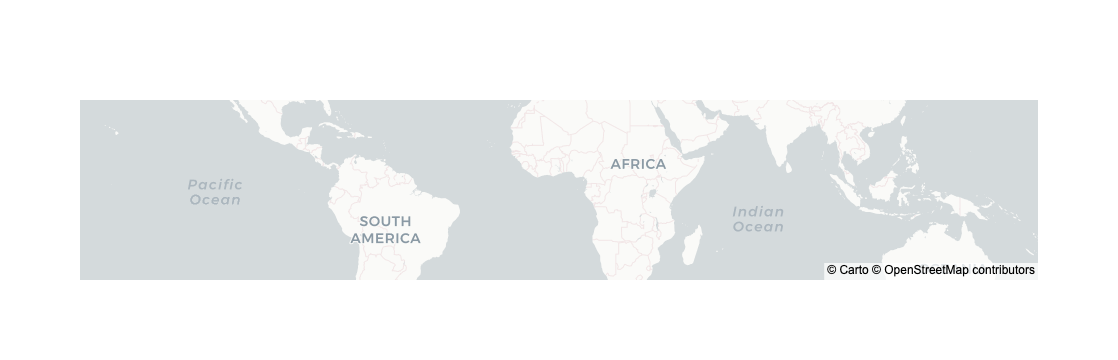

In [25]:
from geostructures import *
from geostructures.collections import FeatureCollection
from geostructures.time import TimeInterval

Coordinate(-0.118092, 51.509865)

box = GeoBox(
    Coordinate(-0.154092, 51.539865),  # Northwest corner
    Coordinate(-0.140592, 51.505665)    # Southeast corner
)

circle = GeoCircle(Coordinate(-0.131092, 51.509865), radius=500)

ellipse = GeoEllipse(
    Coordinate(-0.093092, 51.529865), 
    major_axis=1_000, # The distance between the centerpoint and the furthest point along the circumference
    minor_axis=250,   # The distance between the centerpoint and the closest point along the circumference
    rotation=45       # The angle of rotation (between 0 and 360)
)

ring = GeoRing(
    Coordinate(-0.116092, 51.519865),
    inner_radius=800,
    outer_radius=1000,
)

wedge = GeoRing(
    Coordinate(-0.101092, 51.514865),
    inner_radius=300,
    outer_radius=500,
    angle_min=60,    # The minimum angle of the wedge
    angle_max=190,   # The maximum angle of the wedge
)

linestring = GeoLineString(
    [
        Coordinate(-0.123092, 51.515865), Coordinate(-0.118092, 51.514665), Coordinate(-0.116092, 51.514865),
        Coordinate(-0.116092, 51.518865), Coordinate(-0.108092, 51.512865)
    ]
)

point = GeoPoint(Coordinate(-0.116092, 51.519865))

polygon = GeoPolygon(
    [
        Coordinate(-0.116092, 51.509865), Coordinate(-0.111092, 51.509865), 
        Coordinate(-0.113092, 51.506865), Coordinate(-0.116092, 51.509865)  # Note that the last coordinate is the same as the first
    ]
)

# polygon_with_holes = 

collection = FeatureCollection([box, circle, ellipse, ring, wedge, linestring, point, polygon])
draw_collection(collection)

### Bounding Shapes by Time

Geostructures allows you to define shapes by a point or interval in time using the `dt` parameter. Bounding a shape this way will affect how some operations occur.

In [26]:
# This circle is 'timeless', which is functionally equivalent to eternal
circle = GeoCircle(
    Coordinate(-0.118092, 51.509865), 
    radius=5000
)

# This circle only exists at midnight, January 1st 2020
circle = GeoCircle(
    Coordinate(-0.118092, 51.509865), 
    radius=5000, 
    dt=datetime(2020, 1, 1)
)

# This circle exists between midnight, January 1st 2020 and noon, January 3rd 2020
circle2 = GeoCircle(
    Coordinate(-0.118092, 51.509865), 
    radius=5000, 
    dt=TimeInterval(datetime(2020, 1, 1), datetime(2020, 1, 3, 12))
)

Datetime does not contain timezone information; Zulu/UTC time assumed. (this warning will not repeat)


In [27]:
print("January 2 point inside circle?", GeoPoint(Coordinate(-0.118092, 51.509865), dt=datetime(2020, 1, 2)) in circle2)
print("January 5 point inside circle?", GeoPoint(Coordinate(-0.118092, 51.509865), dt=datetime(2020, 1, 5)) in circle2)

January 2 point inside circle? True
January 5 point inside circle? False


### Shape Operations

Each geostructure comes with several geometric operations you can apply:
* Calculate the centroid
* Draw a circumscribing circle or rectangle around the shape
* Create a list of coordinates that define the outermost border and any holes present
* Test whether a point falls within the shape

Coordinate is in polygon? False


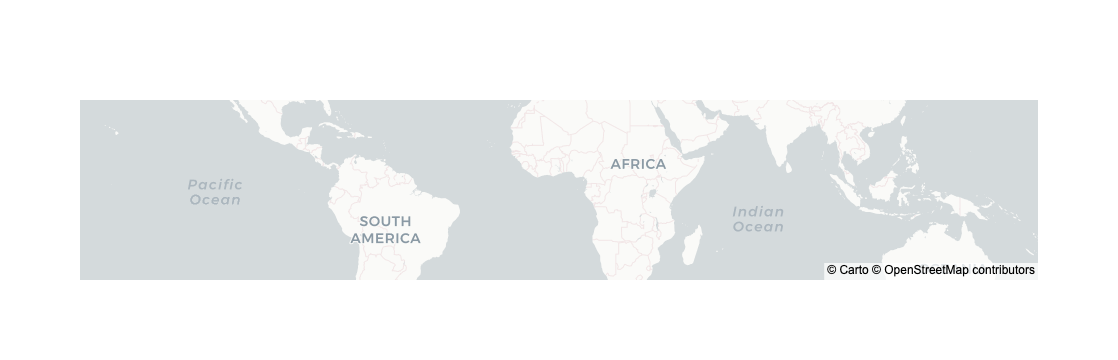

In [28]:
print("Coordinate is in polygon?", Coordinate(-0.118092, 51.509865) in polygon)

circle_around_polygon = polygon.circumscribing_circle()
box_around_polygon = polygon.circumscribing_rectangle()

draw_collection(FeatureCollection([polygon, circle_around_polygon, box_around_polygon]))

In [29]:
circle_around_polygon.bounding_coords()

[<Coordinate(-0.1134253, 51.5108757)>,
 <Coordinate(-0.1128643, 51.5108452)>,
 <Coordinate(-0.1123203, 51.5107545)>,
 <Coordinate(-0.1118099, 51.5106063)>,
 <Coordinate(-0.1113486, 51.5104053)>,
 <Coordinate(-0.1109504, 51.5101574)>,
 <Coordinate(-0.1106274, 51.5098703)>,
 <Coordinate(-0.1103894, 51.5095527)>,
 <Coordinate(-0.1102437, 51.5092141)>,
 <Coordinate(-0.1101947, 51.5088650)>,
 <Coordinate(-0.1102438, 51.5085158)>,
 <Coordinate(-0.1103895, 51.5081773)>,
 <Coordinate(-0.1106275, 51.5078596)>,
 <Coordinate(-0.1109506, 51.5075725)>,
 <Coordinate(-0.1113488, 51.5073247)>,
 <Coordinate(-0.1118100, 51.5071236)>,
 <Coordinate(-0.1123204, 51.5069755)>,
 <Coordinate(-0.1128643, 51.5068848)>,
 <Coordinate(-0.1134253, 51.5068543)>,
 <Coordinate(-0.1139863, 51.5068848)>,
 <Coordinate(-0.1145302, 51.5069755)>,
 <Coordinate(-0.1150406, 51.5071236)>,
 <Coordinate(-0.1155018, 51.5073247)>,
 <Coordinate(-0.1159000, 51.5075725)>,
 <Coordinate(-0.1162231, 51.5078596)>,
 <Coordinate(-0.1164611, 

### Shape Conversions

When you work with other Python libraries, you'll very often need to convert your geostructures into any number of formats. Geostructures provides easy methods for converting shapes into:
* GeoJSON
* Python Shapely objects
* Well Known Text (WKT)

Where supported, any properties given to your geoshape will be injected into the resulting data format. If you've bound your shapes by time, the resulting properties will be named `datetime_start` and `datetime_end`.

In [30]:
polygon = GeoPolygon(
    [
        Coordinate(0.0, 1.0), Coordinate(1.0, 1.0), 
        Coordinate(0.5, 0.0), Coordinate(0.0, 1.0)  # Note that the last coordinate is the same as the first
    ],
    dt=TimeInterval(datetime(2020, 1, 1), datetime(2020, 1, 2)),
    properties={'example property': 'example value'}
)

# With GeoJSON, you can also specify 'root-level' properties to inject
polygon.to_geojson(root_level_property='another example')

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[0.0, 1.0], [1.0, 1.0], [0.5, 0.0], [0.0, 1.0]]]},
 'properties': {'example property': 'example value',
  'datetime_start': '2020-01-01T00:00:00+00:00',
  'datetime_end': '2020-01-02T00:00:00+00:00'},
 'root_level_property': 'another example'}

In [31]:
polygon.to_wkt()

'POLYGON((0.0 1.0,1.0 1.0,0.5 0.0,0.0 1.0))'

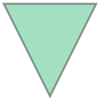

In [32]:
polygon.to_shapely()